## UCL COMP0029 Individual Project for Year 3 BSc
### Robust Robotic Grasping Utilising Touch Sensing - Proposed Learning Framework Notebook
This notebook contains the essential code for training and testing a simplified learning framework for the proposed method - a simple multilayer perceptron to predict grasp outcomes.

### 1. Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import gc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

import seaborn as sns

Set device for `PyTorch` training

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Empty PyTorch cache

In [3]:
gc.collect()
torch.cuda.empty_cache()

Setting fixed random states for reproducibility

In [4]:
torch.manual_seed(69)
np.random.seed(69)

### 2. Load datasets from saved .npy files

To collect data for this experiment, you can run the "Collect Sensory Data" button in the Pybullet simulation. This generates a predefined number of Gaussian grasps randomly generated from a base hand pose. Each individual grasp is considered as an individual experiment, and the data collected from this experiment is split into four, each stored in its own dataset.

For all object models used in this experiment, each object has 4 datasets which include:
- `depth_ds.npy` which stores the depth tactile data from the mounted DIGIT sensors
- `color_ds.npy` which stores the colored (RGB) version of the depth tactile data from the mounted DIGIT sensors
- `poses_ds.npy` which stores the randomly-generated 6d hand poses from the simulation
- `outcomes_ds.npy` which stores the outcomes of each random pose

In [5]:
root = "../datasets/"

object_names = ["block1", "block2", "block3", "cylinder1", "cylinder2", "cylinder3", "mustard_bottle1", "mustard_bottle2", "mustard_bottle3"]

depth_data = np.empty((0, 2, 160, 120))
color_data = np.empty((0, 2, 160, 120, 3))
poses_data = np.empty((0, 6))
grasp_outcomes_data = np.empty((0,))

for object_name in object_names:
    # Construct the relative paths of each dataset and load them into the notebook
    depth_ds_file_path = root + object_name + "_ds/depth_ds.npy"
    depth_data1 = np.load(depth_ds_file_path)

    color_ds_file_path = root + object_name + "_ds/color_ds.npy"
    color_data1 = np.load(color_ds_file_path)

    poses_ds_file_path = root + object_name + "_ds/poses_ds.npy"
    poses_data1 = np.load(poses_ds_file_path)

    grasp_outcomes_ds_file_path = root + object_name + "_ds/grasp_outcomes.npy"
    grasp_outcomes_data1 = np.load(grasp_outcomes_ds_file_path)

    depth_data = np.append(depth_data, depth_data1, axis=0)
    color_data = np.append(color_data, color_data1, axis=0)
    poses_data = np.append(poses_data, poses_data1, axis=0)
    grasp_outcomes_data = np.append(grasp_outcomes_data, grasp_outcomes_data1, axis=0)

These datasets should all be in the form of $(N\times...)$ where $N$ is the number of examples:

In [6]:
print(f"Shape of depth_data: {depth_data.shape}")
print(f"Shape of color_data: {color_data.shape}")
print(f"Shape of poses_data: {poses_data.shape}")
print(f"Shape of grasp_outcomes_data: {grasp_outcomes_data.shape}")

Shape of depth_data: (1440, 2, 160, 120)
Shape of color_data: (1440, 2, 160, 120, 3)
Shape of poses_data: (1440, 6)
Shape of grasp_outcomes_data: (1440,)


Additionally, we confirm the number of successful and unsuccessful grasps recorded. This helps us in the next section to determine how many examples we should include for each class in order to produce a balanced dataset.

In [7]:
print(f"# of sucessesful grasps: {(grasp_outcomes_data == 1).sum()}")
print(f"# of unsuccessful grasps: {(grasp_outcomes_data == 0).sum()}")

# of sucessesful grasps: 720
# of unsuccessful grasps: 720


### 3. Preprocessing

#### 3a. Sampling
We sample a pre-defined number of examples from each class label (successful and unsuccessful grasps) to reduce the computational cost.

In [8]:
sample_size = 600

In [9]:
# Function to sample n samples from the datasets
def sample_data(depth_data, color_data, poses_data, outcomes_data, no_of_examples):
    d, c, p, o = [], [], [], []
    for label in np.unique(outcomes_data):
        indices = np.where(outcomes_data == label)[0]

        for i in range(no_of_examples):
            d.append(depth_data[indices[i]])
            c.append(color_data[indices[i]])
            p.append(poses_data[indices[i]])
            o.append(outcomes_data[indices[i]])
    
    depth_data = torch.from_numpy(np.array(d))
    color_data = torch.from_numpy(np.array(c))
    poses_data = torch.from_numpy(np.array(p))
    outcomes_data = torch.from_numpy(np.array(o))
    return depth_data, color_data, poses_data, outcomes_data

We sample `sample_size` samples:

In [10]:
depth_data, color_data, poses_data, grasp_outcomes_data = sample_data(depth_data, color_data, poses_data, grasp_outcomes_data, no_of_examples=sample_size)

In [11]:
print(f"Shape of depth_data: {depth_data.shape}")
print(f"Shape of color_data: {color_data.shape}")
print(f"Shape of poses_data: {poses_data.shape}")
print(f"Shape of grasp_outcomes_data: {grasp_outcomes_data.shape}")
print(f"# of sucessesful grasps: {(grasp_outcomes_data == 1).sum()}")
print(f"# of unsuccessful grasps: {(grasp_outcomes_data == 0).sum()}")

Shape of depth_data: torch.Size([1200, 2, 160, 120])
Shape of color_data: torch.Size([1200, 2, 160, 120, 3])
Shape of poses_data: torch.Size([1200, 6])
Shape of grasp_outcomes_data: torch.Size([1200])
# of sucessesful grasps: 600
# of unsuccessful grasps: 600


#### 3b. Preprocessing

In [12]:
def normalize(tensor):
    # Normalize & standardize each column
    mean = torch.mean(tensor, axis=0)
    std = torch.std(tensor, axis=0)
    tensor = (tensor - mean) / std
    tensor[torch.isnan(tensor)] = 0
    tensor[torch.isinf(tensor)] = 0
    return tensor


def downsample_2d_tensor(tensor, factor=2):
    return torch.nn.functional.avg_pool2d(tensor.unsqueeze(0), kernel_size=factor, stride=factor, padding=0).squeeze(0)


def downsample_3d_tensor(tensor, factor=2):
    pooling_kernel = 2
    pooling_layer = torch.nn.AvgPool2d(kernel_size=pooling_kernel, stride=pooling_kernel)
    downsampled_tensor = pooling_layer(tensor.permute(0, 3, 1, 2))
    downsampled_tensor = downsampled_tensor.permute(0, 2, 3, 1)
    
    return downsampled_tensor

#### 3c. Preparing datasets for training

We will use a tactile+visual data representation with CNNs as the input for our MLP approach. We concatenate the depth and color to get our tactile dataset, then concatenate the tactile and visual datasets together.

In [13]:
depth_data = torch.cat([depth_data[:, 0, :, :], depth_data[:, 1, :, :]], dim=2)
color_data = torch.cat([color_data[:, 0, :, :, :], color_data[:, 1, :, :, :]], dim=2)
print(f"Shape of depth_data: {depth_data.shape}")
print(f"Shape of color_data: {color_data.shape}")

depth_ds = normalize(depth_data)
color_ds = normalize(color_data)
visual_ds = torch.from_numpy(np.nan_to_num(normalize(poses_data)))
visual_ds

Shape of depth_data: torch.Size([1200, 160, 240])
Shape of color_data: torch.Size([1200, 160, 240, 3])


tensor([[ 0.1775, -1.6619, -0.4908, -0.1711, -0.9327,  0.7954],
        [ 0.2279, -1.0723, -1.0299, -0.1653, -0.9533,  0.7805],
        [ 0.5478, -1.0688, -0.5870, -0.1623, -0.9445,  0.8073],
        ...,
        [-1.1303,  1.6146,  0.6885, -0.1587, -0.4618, -1.9818],
        [-0.8063,  1.6235,  0.3125, -0.1588, -0.4025, -1.9796],
        [-0.6923,  1.4715,  0.1793, -0.1765, -0.3876, -1.9806]],
       dtype=torch.float64)

In [14]:
# tactile_ds = torch.cat([depth_ds, color_ds], dim=1)
# complete_ds = torch.cat([tactile_ds, visual_ds], dim=1)
tactile_ds = torch.cat([depth_ds.unsqueeze(-1), color_ds], dim=-1)
tactile_ds = torch.nan_to_num(tactile_ds)
complete_ds = torch.cat([tactile_ds.reshape(tactile_ds.shape[0], -1), visual_ds], dim=1)
complete_ds = torch.nan_to_num(complete_ds)
print(tactile_ds.shape, complete_ds.shape)

torch.Size([1200, 160, 240, 4]) torch.Size([1200, 153606])


#### 3d. CNN dimensionality reduction

In [15]:
# A simple convolutional neural network that extracts features from an input tensor
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=3)


    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        return x

In [16]:
# Preprocess data using CNN feature extraction
cnn = FeatureExtractorCNN()
cnn_tactile = torch.cat([cnn(img.float().permute(2,0,1)).unsqueeze(0) for img in tactile_ds])
cnn_tactile = cnn_tactile.reshape(cnn_tactile.shape[0], -1)
cnn_tactile.shape

torch.Size([1200, 512])

### 4. Testing different data representations

In our MLP model, there are two fully connected (dense) layers, each with an activation function (ReLU for the first layer and no activation for the second layer). The input size, hidden size, and output size are parameters that need to be specified when creating an instance of the MLP.

In [17]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.parameters())

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    
    def train_mlp(self, epochs, X_train, y_train):
        self.losses = []
        for _ in range(epochs):
            inputs = torch.from_numpy(X_train).float()
            labels = y_train.float().view(-1, 1)

            # Zero the gradients
            self.optimizer.zero_grad()

            # Forward pass
            preds = self(inputs)
            loss = self.criterion(preds, labels)
            self.losses.append(loss.item())

            # Backward pass and optimization
            loss.backward()
            self.optimizer.step()
        
    def eval_mlp(self, X_test, y_test):
        # Evaluate the performance of the model on the testing set
        with torch.no_grad():
            inputs = torch.from_numpy(X_test).float()
            labels = y_test.float().view(-1, 1)

            # Forward pass
            final_preds = self(inputs)
            predicted = (final_preds > 0).float()
            
            # Confusion matrix
            cm = confusion_matrix(y_test, predicted)
            sns.heatmap(cm, linewidths=1, annot=True, fmt='g')

            # Accuracy
            accuracy = (predicted == labels).float().mean()
            print(f"Accuracy of MLP model: {accuracy*100:.2f}%")
    
    def plot_losses(self):
        plt.plot(self.losses)
        plt.xlabel('Epochs')
        plt.ylabel('Training Loss')
        plt.show


#### 4a. Tactile only + CNN -> MLP

In [18]:
X_train, X_test, y_train, y_test = train_test_split(cnn_tactile.detach().numpy(), grasp_outcomes_data, test_size=0.2, random_state=0)

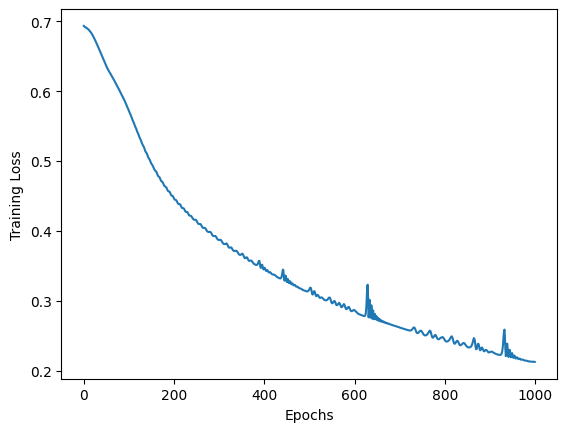

In [19]:
mlp4a = MLP(input_size=512, hidden_size=64, output_size=1)
mlp4a.train_mlp(epochs=1000, X_train=X_train, y_train=y_train)
mlp4a.plot_losses()

Accuracy of MLP model: 72.50%


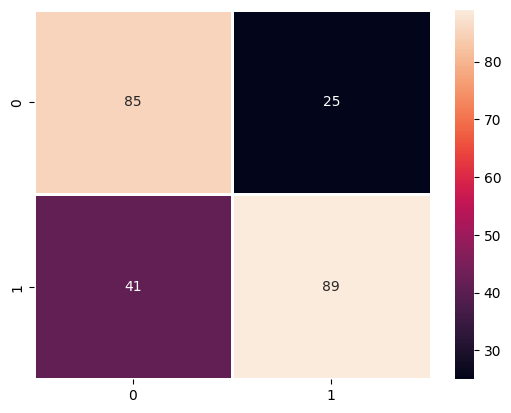

In [20]:
mlp4a.eval_mlp(X_test=X_test, y_test=y_test)

### 4b. Visual only + CNN -> MLP

In [21]:
X_train, X_test, y_train, y_test = train_test_split(visual_ds.detach().numpy(), grasp_outcomes_data, test_size=0.2, random_state=0)

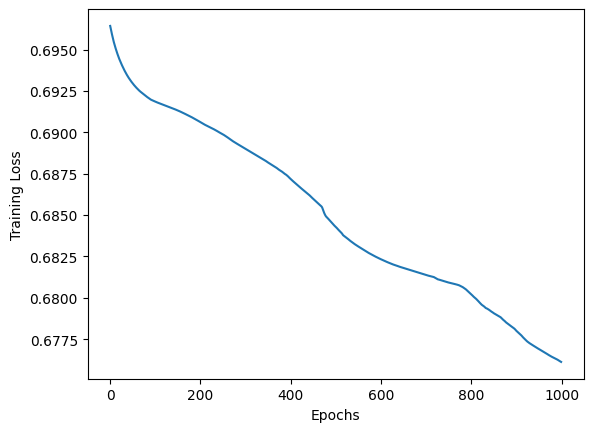

In [22]:
mlp4b = MLP(input_size=6, hidden_size=4, output_size=1)
mlp4b.train_mlp(epochs=1000, X_train=X_train, y_train=y_train)
mlp4b.plot_losses()

Accuracy of MLP model: 48.33%


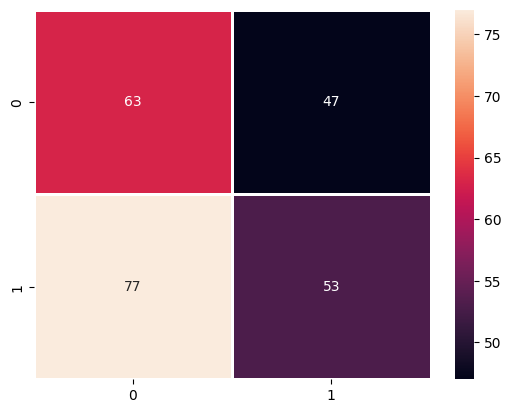

In [23]:
mlp4b.eval_mlp(X_test=X_test, y_test=y_test)

### 5. Proposed method - All data -> MLP

We split our data into training and testing datasets for future sections.
We will only use the `complete_ds` for this approach. 

In [24]:
# We simply combine the cnn-processed tactile data (from Section 5.3.1) with the visual data
cnn5_complete_ds = torch.cat([cnn_tactile.reshape(cnn_tactile.shape[0], -1), visual_ds], dim=1)
cnn5_complete_ds.shape

torch.Size([1200, 518])

In [25]:
X_cnn_complete_train, X_cnn_complete_test, y_cnn_complete_train, y_cnn_complete_test = train_test_split(cnn5_complete_ds.detach().numpy(), grasp_outcomes_data, test_size=0.2, random_state=0)

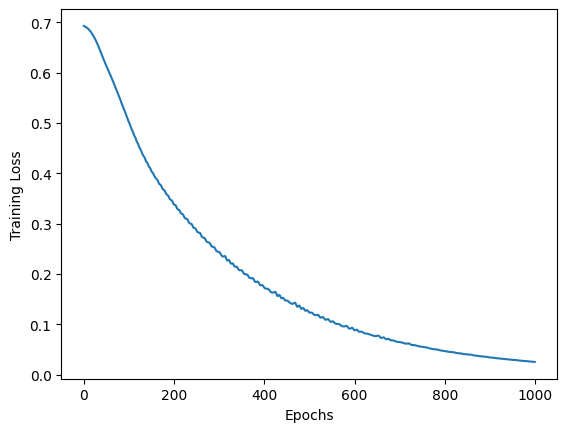

In [26]:
mlp5 = MLP(input_size=518, hidden_size=64, output_size=1)
mlp5.train_mlp(epochs=1000, X_train=X_cnn_complete_train, y_train=y_cnn_complete_train)
mlp5.plot_losses()

Accuracy of MLP model: 75.83%


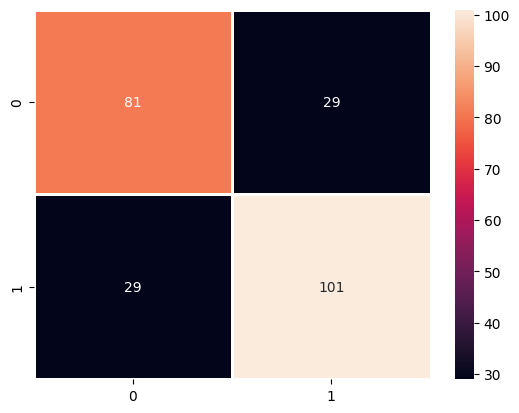

In [27]:
mlp5.eval_mlp(X_test=X_cnn_complete_test, y_test=y_cnn_complete_test)

### 6. MLP with object features
We additionally train our MLP with tactile + visual data, where visual data consists of end effector poses and object features.

#### 6a. Clustering for object features using PCA
For determining the successfulness of object feature representation in identifying various objects

In [28]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

np.set_printoptions(precision=2, formatter={'float_kind': "{:.3f}".format})

### Loading object features

In [29]:
### Object features
block_features = np.array([
    [0.025, 0.05, 0.05, 0., 0., 0., 0., 0., 0.],
    [0.03, 0.025, 0.045, 0., 0., 0., 0., 0., 0.],
    [0.05, 0.025, 0.04, 0., 0., 0., 0., 0., 0.],
])

cylinder_features = np.array([
    [0.04, 0.04, 0.05, 950.21606561, 14540.28434464, 950.21606561, 14540.28434464, 950.21606561, 14540.28434464],
    [0.045, 0.045, 0.035, 750.78800246, 11488.6197291, 750.78800246, 11488.6197291, 750.78800246, 11488.6197291],
    [0.034, 0.034, 0.045, 1315.17794549, 20124.96103064, 1315.17794549, 20124.96103064, 1315.17794549, 20124.96103064]
])

bottle_features = np.array([
    [0.06, 0.04, 0.04, 43195.64459266, 114198.0441697 , 45229.93706864, 135651.61794731, 75768.06626518,  83802.00991944],
    [0.04, 0.06, 0.06, 68993.34322089, 220902.86884084, 75354.47923164, 239160.99530455, 109695.41304924, 147938.06047763],
    [0.04, 0.06, 0.04, 61744.75459905, 168925.8805044 , 68143.84372052, 148775.07141178, 73102.67367022, 102953.40831915]
])

object_names = {0: 'cylinder', 1: 'block', 2: 'bottle'}

### Feature transformation

Concatenating features together

In [30]:
objects = (block_features, cylinder_features, bottle_features)
features = np.concatenate(objects)
labels = np.array([1, 1, 1, 0, 0, 0, 2, 2, 2])
features

array([[0.025, 0.050, 0.050, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.030, 0.025, 0.045, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.050, 0.025, 0.040, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.040, 0.040, 0.050, 950.216, 14540.284, 950.216, 14540.284,
        950.216, 14540.284],
       [0.045, 0.045, 0.035, 750.788, 11488.620, 750.788, 11488.620,
        750.788, 11488.620],
       [0.034, 0.034, 0.045, 1315.178, 20124.961, 1315.178, 20124.961,
        1315.178, 20124.961],
       [0.060, 0.040, 0.040, 43195.645, 114198.044, 45229.937,
        135651.618, 75768.066, 83802.010],
       [0.040, 0.060, 0.060, 68993.343, 220902.869, 75354.479,
        239160.995, 109695.413, 147938.060],
       [0.040, 0.060, 0.040, 61744.755, 168925.881, 68143.844,
        148775.071, 73102.674, 102953.408]])

Standardize the data

In [31]:
scaler = StandardScaler()
features = scaler.fit_transform(features)
features

array([[-1.558, 0.639, 0.707, -0.707, -0.765, -0.702, -0.760, -0.700,
        -0.817],
       [-1.054, -1.386, 0.000, -0.707, -0.765, -0.702, -0.760, -0.700,
        -0.817],
       [0.964, -1.386, -0.707, -0.707, -0.765, -0.702, -0.760, -0.700,
        -0.817],
       [-0.045, -0.171, 0.707, -0.673, -0.583, -0.671, -0.586, -0.677,
        -0.536],
       [0.460, 0.234, -1.414, -0.680, -0.621, -0.677, -0.622, -0.682,
        -0.595],
       [-0.650, -0.657, 0.000, -0.660, -0.513, -0.659, -0.519, -0.668,
        -0.428],
       [1.973, -0.171, -0.707, 0.846, 0.664, 0.789, 0.869, 1.125, 0.801],
       [-0.045, 1.449, 2.121, 1.774, 1.999, 1.781, 2.112, 1.942, 2.039],
       [-0.045, 1.449, -0.707, 1.513, 1.349, 1.544, 1.026, 1.061, 1.171]])

### PCA

In [32]:
def pca(data, k):
    pca = PCA(n_components=k)
    pca.fit(data)
    print(f"Variance captured: {pca.explained_variance_ratio_}")
    return pca.transform(data)

Variance captured: [0.746 0.169]


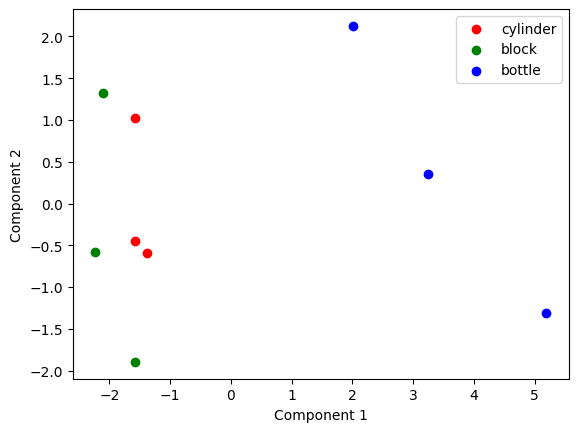

In [33]:
### Plot 2-feature PCA results
pca2d = pca(features, k=2)

colors = ['r', 'g', 'b']
for i, c in zip(np.unique(labels), colors):
    plt.scatter(pca2d[labels == i, 0], pca2d[labels == i, 1], c=c, label=object_names[i])

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

Variance captured: [0.746 0.169 0.059]


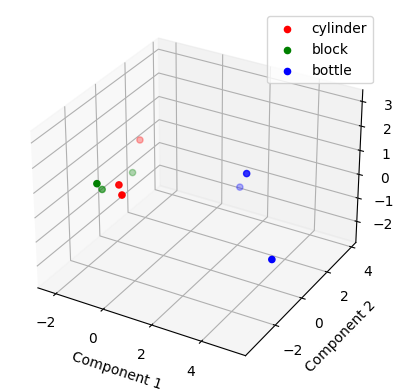

In [34]:
### Plot 3-feature PCA results
pca3d = pca(features, k=3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
for i, c in zip(np.unique(labels), colors):
    ax.scatter(pca3d[labels == i, 0], pca3d[labels == i, 1], pca3d[labels == i, 2], c=c, label=object_names[i])

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_aspect('equal', 'box')
ax.legend()
plt.show()

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


clf = LogisticRegression()
clf.fit(features, labels)
ypred = clf.predict(features)

accuracy = accuracy_score(labels, ypred) * 100
accuracy

88.88888888888889

#### 6b. MLP Training
Complete dataset: Tactile + visual (ee pose & geometric features) + CNN + PCA

In [41]:
object_names = ["block1", "block2", "block3", "cylinder1", "cylinder2", "cylinder3", "mustard_bottle1", "mustard_bottle2", "mustard_bottle3"]
object_features = np.concatenate((block_features, cylinder_features, bottle_features))

mlp_final_ds = []
mlp_grasp_outcomes_ds = []

for i in range(len(object_names)):
    object_name = object_names[i]

    # Load datasets
    depth_ds_file_path = root + object_name + "_ds/depth_ds.npy"
    depth_data = torch.from_numpy(np.load(depth_ds_file_path))

    color_ds_file_path = root + object_name + "_ds/color_ds.npy"
    color_data = torch.from_numpy(np.load(color_ds_file_path))

    poses_ds_file_path = root + object_name + "_ds/poses_ds.npy"
    poses_data = torch.from_numpy(np.load(poses_ds_file_path))

    grasp_outcomes_ds_file_path = root + object_name + "_ds/grasp_outcomes.npy"
    grasp_outcomes_data = torch.from_numpy(np.load(grasp_outcomes_ds_file_path))

    depth_data = torch.cat([depth_data[:, 0, :, :], depth_data[:, 1, :, :]], dim=2)
    color_data = torch.cat([color_data[:, 0, :, :, :], color_data[:, 1, :, :, :]], dim=2)

    depth_ds = normalize(depth_data)
    color_ds = normalize(color_data)
    visual_ds = torch.from_numpy(np.nan_to_num(normalize(poses_data)))

    tactile_ds = torch.cat([depth_ds.unsqueeze(-1), color_ds], dim=-1)
    tactile_ds = torch.nan_to_num(tactile_ds)
    complete_ds = torch.cat([tactile_ds.reshape(tactile_ds.shape[0], -1), visual_ds], dim=1)
    complete_ds = torch.nan_to_num(complete_ds)

    cnn = FeatureExtractorCNN()
    cnn_tactile = torch.cat([cnn(img.float().permute(2,0,1)).unsqueeze(0) for img in tactile_ds])
    cnn_tactile = cnn_tactile.reshape(cnn_tactile.shape[0], -1)
    
    cnn6_complete_ds = torch.cat([cnn_tactile.reshape(cnn_tactile.shape[0], -1), visual_ds], dim=1)

    # Prepare object geometric features
    geometric_features = object_features[i]
    geometric_features = geometric_features.reshape(1, 9)

    # Combine the final data
    final_dataset = np.concatenate((cnn6_complete_ds.detach().numpy(), np.tile(geometric_features, (cnn6_complete_ds.shape[0], 1))), axis=1)
    
    mlp_final_ds.append(final_dataset)
    mlp_grasp_outcomes_ds.append(grasp_outcomes_data)

In [67]:
mlp_final_ds = np.vstack(mlp_final_ds)
mlp_final_ds = np.array(normalize(torch.from_numpy(mlp_final_ds)))
mlp_grasp_outcomes_ds = torch.from_numpy(np.concatenate(np.vstack(mlp_grasp_outcomes_ds)))

In [68]:
X_final_complete_train, X_final_complete_test, y_final_complete_train, y_final_complete_test = train_test_split(mlp_final_ds, mlp_grasp_outcomes_ds, test_size=0.2, random_state=0)

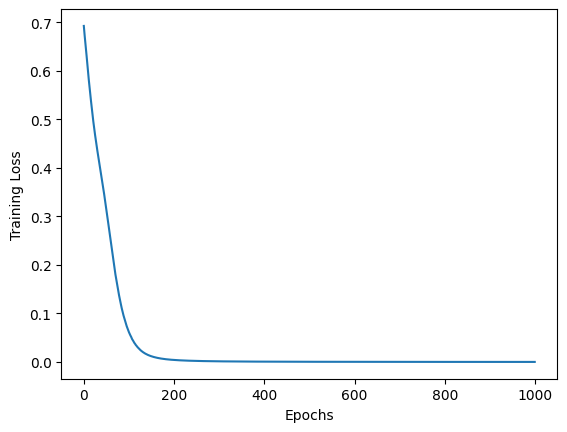

In [73]:
mlp6 = MLP(input_size=527, hidden_size=64, output_size=1)
mlp6.train_mlp(epochs=1000, X_train=X_final_complete_train, y_train=y_final_complete_train)
mlp6.plot_losses()

Accuracy of MLP model: 77.78%


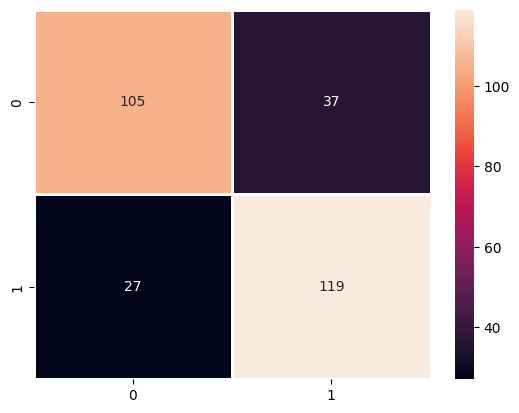

In [75]:
mlp6.eval_mlp(X_test=X_final_complete_test, y_test=y_final_complete_test)